In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import plot_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import math


In [ ]:
# Data loading
# Download data from Yahoo Finance
ticker = 'TSLA'
Tsla_data = yf.download(ticker, start="2013-11-30", end="2023-11-30")
Tsla_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-02,8.423333,8.570000,8.262000,8.278000,8.278000,116268000
2013-12-03,8.845333,9.662667,8.772667,9.646667,9.646667,385236000
2013-12-04,9.621333,9.628667,9.142000,9.263333,9.263333,197215500
2013-12-05,9.343333,9.556667,9.300000,9.365333,9.365333,139326000
2013-12-06,9.434000,9.499333,9.086667,9.157333,9.157333,118644000
...,...,...,...,...,...,...
2023-11-22,242.039993,244.009995,231.399994,234.210007,234.210007,117950600
2023-11-24,233.750000,238.750000,232.330002,235.449997,235.449997,65125200
2023-11-27,236.889999,238.330002,232.100006,236.080002,236.080002,112031800


In [ ]:

# Data preprocessing for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(Tsla_data['Close'].values.reshape(-1, 1))

scaled_data.shape

(2516, 1)

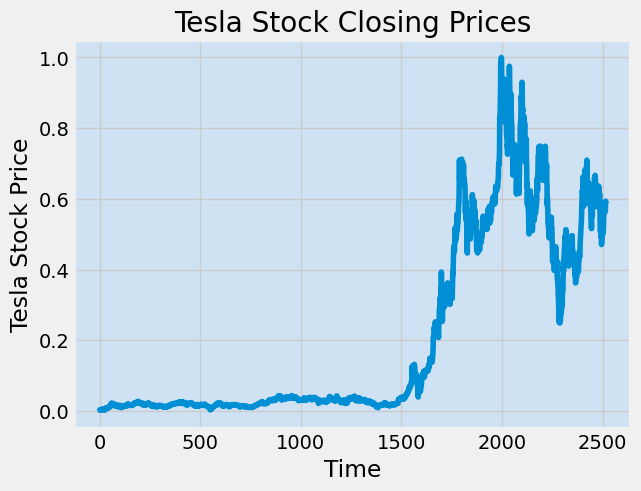

In [ ]:
# Plot the stock data
plt.plot(scaled_data)
plt.title('Tesla Stock Closing Prices')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.gca().set_facecolor('#cfe2f3')
plt.grid(True)
plt.show()

In [ ]:
# Create the time series data structure
look_back = 60
train_size = int(len(scaled_data) * 0.60)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - look_back:]

# Separate normalization for training and testing data
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaler_test = MinMaxScaler(feature_range=(0, 1))

train_data_scaled = scaler_train.fit_transform(train_data)
test_data_scaled = scaler_test.fit_transform(test_data)

# generate sequences for training and testing
train_generator = TimeseriesGenerator(train_data_scaled, train_data_scaled,
                                       length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(test_data_scaled, test_data_scaled,
                                      length=look_back, batch_size=1)


In [ ]:
# Model defination
tsla_model = Sequential()
tsla_model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
tsla_model.add(Dropout(0.2))
tsla_model.add(LSTM(units=50, return_sequences=True))
tsla_model.add(Dropout(0.2))
tsla_model.add(LSTM(units=50))
tsla_model.add(Dropout(0.2))
tsla_model.add(Dense(units=1))
tsla_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Display the model summary
tsla_model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_17 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_18 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_18 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_19 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_19 (Dropout)        (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [ ]:
# Train the LSTM model with early stopping
tsla_model.fit(train_generator, epochs=30, batch_size=32, validation_data=test_generator, callbacks=[early_stopping])

Epoch 1/30
73/73 [==============================] - 27s 258ms/step - loss: 0.0430 - val_loss: 0.0063
Epoch 2/30
73/73 [==============================] - 18s 249ms/step - loss: 0.0150 - val_loss: 0.0054
Epoch 3/30
73/73 [==============================] - 26s 365ms/step - loss: 0.0101 - val_loss: 0.0059
Epoch 4/30
73/73 [==============================] - 19s 263ms/step - loss: 0.0107 - val_loss: 0.0043
Epoch 5/30
73/73 [==============================] - 19s 269ms/step - loss: 0.0097 - val_loss: 0.0047
Epoch 6/30
73/73 [==============================] - 18s 255ms/step - loss: 0.0096 - val_loss: 0.0037
Epoch 7/30
73/73 [==============================] - 27s 374ms/step - loss: 0.0081 - val_loss: 0.0052
Epoch 8/30
73/73 [==============================] - 28s 385ms/step - loss: 0.0093 - val_loss: 0.0036
Epoch 9/30
73/73 [==============================] - 28s 385ms/step - loss: 0.0076 - val_loss: 0.0029
Epoch 10/30
73/73 [==============================] - 27s 376ms/step - loss: 0.0073 - val_lo

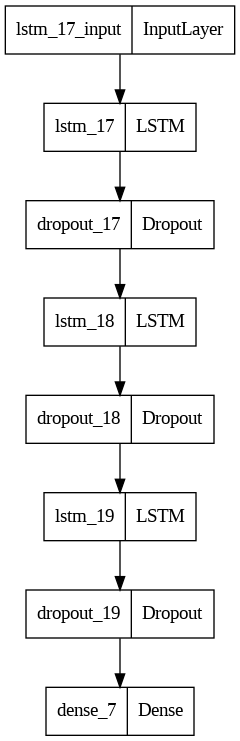

In [ ]:
plot_model(tsla_model)

In [ ]:
# Model Evaluation
model_predict = tsla_model.predict(test_generator)
model_predict = scaler_test.inverse_transform(model_predict)
actual_prices = scaler_test.inverse_transform(test_data[look_back:])
train_rmse = math.sqrt(mean_squared_error(train_data[look_back:look_back+len(model_predict)], model_predict))
test_rmse = math.sqrt(mean_squared_error(actual_prices, model_predict))

print(f"Root Mean Squared Error for Training Data: {train_rmse}")
print(f"Root Mean Squared Error for Testing Data: {test_rmse}")


1007/1007 [==============================] - 15s 13ms/step
Root Mean Squared Error for Training Data: 0.4966542900482715
Root Mean Squared Error for Testing Data: 0.04404010453755587


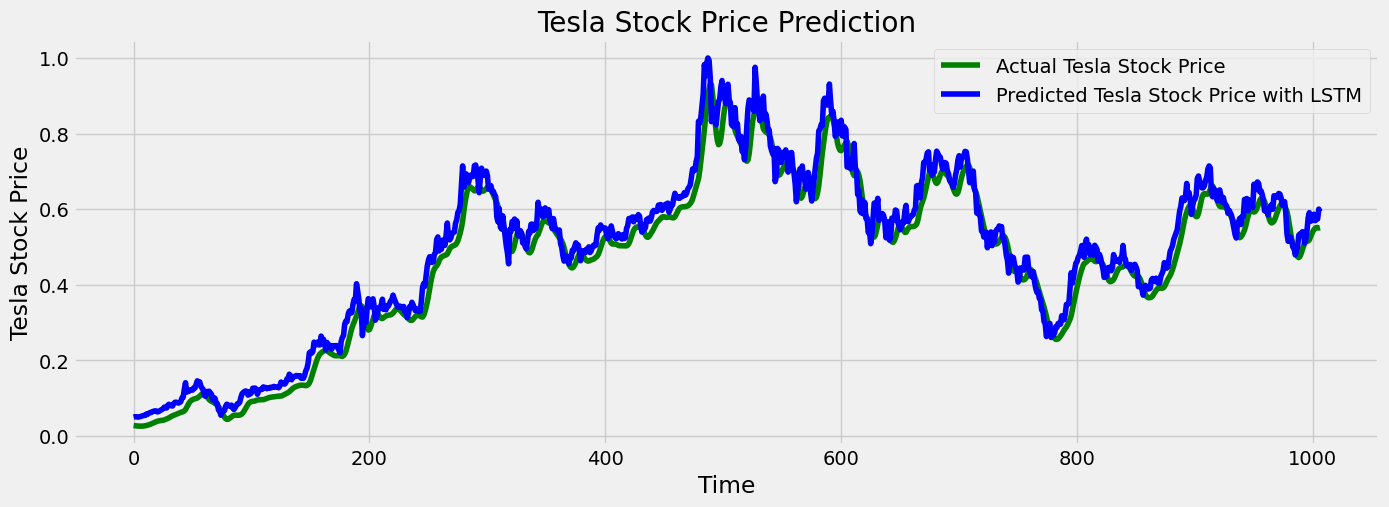

In [ ]:
# Plot the actual vs predicted prices on the testing set
plt.figure(figsize=(15, 5))
plt.plot(model_predict, color='green', label='Actual Tesla Stock Price')
plt.plot(actual_prices, color='blue', label='Predicted Tesla Stock Price with LSTM')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

In [104]:
# Define the function for predicting future days
# Define the function for predicting future days
def predict_future_days(model, base_data, days_to_predict, scaler, look_back=60):
    future_predictions = []
    input_data = base_data[-look_back:].reshape(1, look_back, 1)

    for _ in range(days_to_predict):
        prediction = model.predict(input_data)
        future_predictions.append(prediction[0, 0])

        # Update the input data to include the prediction and exclude the oldest data point
        input_data = np.append(input_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

    # Invert the scaling
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions
# Predict future days
days_to_predict = 60
future_days = predict_future_days(tsla_model, scaled_data, days_to_predict, scaler, look_back)


1/1 [==============================] - 0s 42ms/step


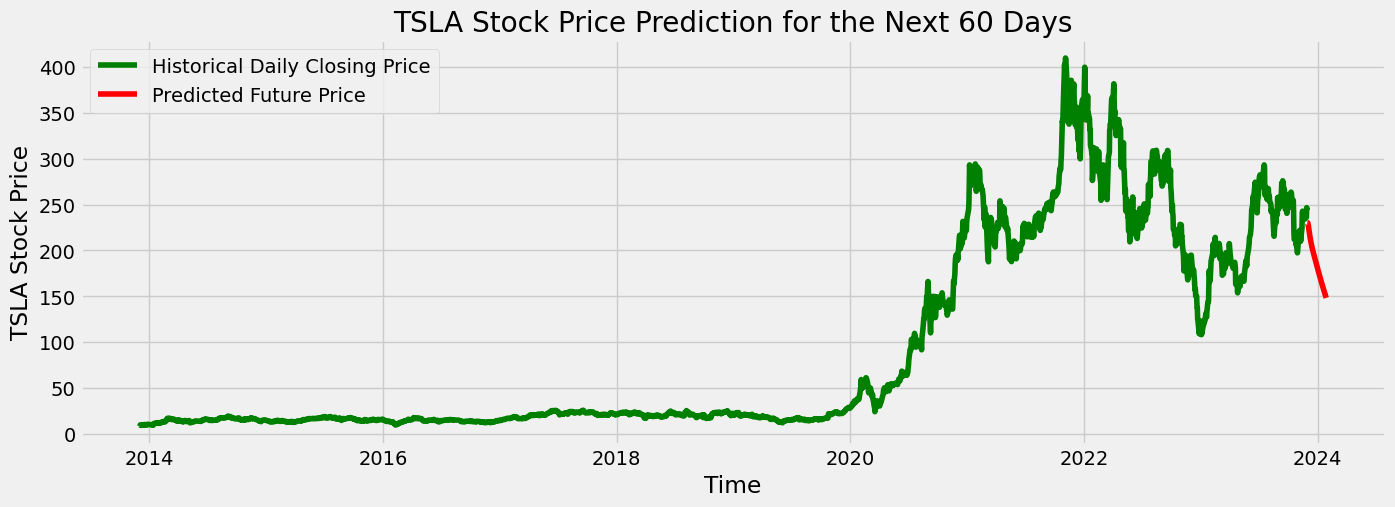

In [105]:
# Plot the predictions for future days
predicted_dates = pd.date_range(start=Tsla_data.index[-1] + pd.Timedelta(days=1), periods=days_to_predict)

plt.figure(figsize=(15, 5))
plt.plot(Tsla_data.index, Tsla_data['Close'], color='green', label='Historical Daily Closing Price')
plt.plot(predicted_dates, future_days, color='red', label='Predicted Future Price')
plt.title(f'TSLA Stock Price Prediction for the Next {days_to_predict} Days')
plt.xlabel('Time')
plt.ylabel('TSLA Stock Price')
plt.legend()
plt.show()